In [12]:
# Utilities相關函式庫
import os
import numpy as np
import math

# 圖像處理/展現的相關函式庫
import cv2
import dlib
import matplotlib.pyplot as plt

In [13]:

# 使用dlib自帶的frontal_face_detector作為我們的人臉偵測器
face_detector = dlib.get_frontal_face_detector()

# 載入圖像檔
img = cv2.imread('demo.jpg');
size = img.shape

In [14]:

# 使用檢測器進行人臉檢測dets為返回的結果
# 第二個參數中的1表示把原始圖像變大，讓演算法能夠發現更多的人臉。
dets = face_detector(img, 1) 

# dets的元素個數即為偵測到臉的個數
print("Number of faces detected: {}".format(len(dets)))

Number of faces detected: 1


In [15]:
print('Loading feature extraction model')

# 載入dlib的人臉landmarks偵測器
face_landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

Loading feature extraction model


In [16]:

# 將dlib偵測到的人臉68個特徵點取出
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

# 偵測單一人臉的臉部特徵(假設圖像中只有一個人)
def get_landmarks(im, face_detector, shape_predictor):
    rects = face_detector(im, 1)
    shape = shape_predictor(im, rects[0])
    coords = shape_to_np(shape, dtype="int")
        
    return coords

In [17]:
# 取得單1人臉的68個人臉關鍵點的座標
landmarks = get_landmarks(img, face_detector, face_landmark_predictor)

# 鼻尖 Nose tip: 34
nose_tip = landmarks[33:34]

# 下巴 Chin: 9
chin = landmarks[8:9]

# 左眼左角 Left eye left corner: 37
left_eye_corner = landmarks[36:37]

# 右眼右角 Right eye right corner: 46
right_eye_corner = landmarks[45:46]

# 嘴巴左角 Left Mouth corner: 49
left_mouth_corner = landmarks[48:49]

# 嘴巴右角 Right Mouth corner: 55
right_mouth_corner = landmarks[54:55]

# 把相關的6個座標串接起來
face_points = np.concatenate((nose_tip, chin, left_eye_corner, right_eye_corner, left_mouth_corner, right_mouth_corner))
face_points = face_points.astype(np.double)

print(face_points.shape)
print(face_points.dtype)

(6, 2)
float64


In [18]:
# 3維模型的座標點 (使用一般的3D人臉模型的座標點)
model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-225.0, 170.0, -135.0),     # Left eye left corner
                            (225.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner                         
                        ])

In [19]:
# 焦距
focal_length = size[1] 
print("Cameria [focal_length]: ", focal_length)

# 照像機內部成像的中心點(w, h)
center = (size[1]/2, size[0]/2)

# 照像機參數 (Camera internals )
camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )
 
print("Camera Matrix :\n {0}".format(camera_matrix))


# 扭曲係數
dist_coeffs = np.zeros((4,1)) # 假設沒有鏡頭的成像扭曲 (no lens distortion)

# 使用OpenCV的solvePnP函數來計算人臉的旋轉與位移
#(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix
#                                                              , dist_coeffs, flags=cv2.CV_ITERATIVE)
# 參數:
#   model_points 3維模型的座標點
#   image_points 2維圖像的座標點
#   camera_matrix 照像機矩陣
#   dist_coeffs 照像機扭曲係數
#   flags: cv2.SOLVEPNP_ITERATIVE
(success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, face_points, camera_matrix
                                                              , dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

print("Rotation Vector:\n {0}".format(rotation_vector)) # 旋轉向量
print("Translation Vector:\n {0}".format(translation_vector)) # 位移向量

Cameria [focal_length]:  640
Camera Matrix :
 [[640.   0. 320.]
 [  0. 640. 200.]
 [  0.   0.   1.]]
Rotation Vector:
 [[-0.12794744]
 [ 3.27157313]
 [-0.41345239]]
Translation Vector:
 [[  244.82440188]
 [   -8.48133243]
 [-2740.9241835 ]]


In [20]:

# 計算歐拉角
rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
proj_matrix = np.hstack((rvec_matrix, translation_vector))
eulerAngles = -cv2.decomposeProjectionMatrix(proj_matrix)[6]

yaw   = eulerAngles[1]
pitch = eulerAngles[0]
roll  = eulerAngles[2]

if pitch > 0:
  pitch = 180 - pitch
elif pitch < 0:
  pitch = -180 - pitch
yaw = -yaw

print("抬頭(+)/低頭(-) [pitch]: ", pitch) # 抬頭(+)/低頭(-)
print("右轉(+)/左轉(-) [yaw]  : ", yaw)   # 右轉(+)/左轉(-)
print("右傾(+)/左傾(-) [roll] : ", roll)  # 右傾(+)/左傾(-)

抬頭(+)/低頭(-) [pitch]:  [14.13003347]
右轉(+)/左轉(-) [yaw]  :  [-9.5618414]
右傾(+)/左傾(-) [roll] :  [176.70851692]


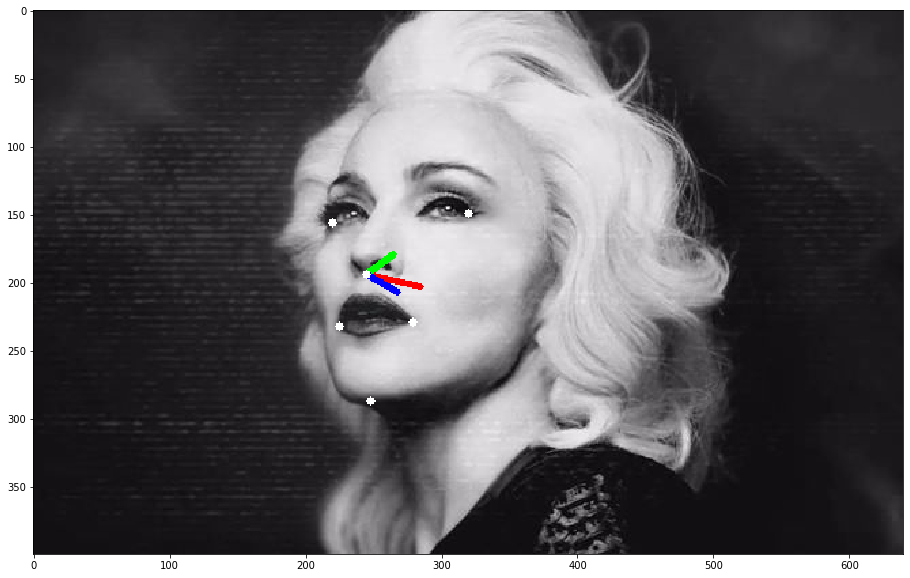

抬頭(+)/低頭(-) [pitch]:  [14.13003347]
右轉(+)/左轉(-) [yaw]  :  [-9.5618414]
右傾(+)/左傾(-) [roll] :  [176.70851692]


In [21]:
# 投射一個3D的點 (100.0, 0, 0)到2D圖像的座標上
(x_end_point2D, jacobian) = cv2.projectPoints(np.array([(100.0, 0.0, 0.0)]), rotation_vector
                                                 , translation_vector, camera_matrix, dist_coeffs)

# 投射一個3D的點 (0, 100.0, 0)到2D圖像的座標上
(y_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 100.0, 0.0)]), rotation_vector
                                                 , translation_vector, camera_matrix, dist_coeffs)

# 投射一個3D的點 (0, 0, 100.0)到2D圖像的座標上
(z_end_point2D, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 100.0)]), rotation_vector
                                           , translation_vector, camera_matrix, dist_coeffs)


# 以 Nose tip為中心點畫出x, y, z的軸線
p_nose = (int(face_points[0][0]), int(face_points[0][1]))

p_x = (int(x_end_point2D[0][0][0]), int(x_end_point2D[0][0][1]))

p_y = (int(y_end_point2D[0][0][0]), int(y_end_point2D[0][0][1]))

p_z = (int(z_end_point2D[0][0][0]), int(z_end_point2D[0][0][1]))

cv2.line(img, p_nose, p_x, (0,0,255), 3)  # X軸 (紅色)
cv2.line(img, p_nose, p_y, (0,255,0), 3)  # Y軸 (綠色)
cv2.line(img, p_nose, p_z, (255,0,0), 3)  # Z軸 (藍色)

# 把6個基準點標註出來
for p in face_points:
    cv2.circle(img, (int(p[0]), int(p[1])), 3, (255,255,255), -1)

# 秀出圖像
plt.figure(figsize=(20,10))
plt.imshow(img[:,:,::-1]) # 從BGR -> RGB
plt.show()

print("抬頭(+)/低頭(-) [pitch]: ", pitch) # 抬頭(+)/低頭(-)
print("右轉(+)/左轉(-) [yaw]  : ", yaw)   # 右轉(+)/左轉(-)
print("右傾(+)/左傾(-) [roll] : ", roll)  # 右傾(+)/左傾(-)